In [26]:
import pandas as pd

# Especifica la ruta del archivo CSV
file_path = 'C:/Users/g97rojasmf/Documents/Tesis/df_mora_prestamos2.csv'

# Cargar el CSV en un DataFrame
df_mora_prestamos = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame para verificar la carga

In [2]:
import pandas as pd

# Supongamos que df_mora_prestamos es tu DataFrame
# Si no has cargado el DataFrame, puedes hacerlo de la siguiente manera:
# df_mora_prestamos = pd.read_csv('tu_archivo.csv')

# Contar la cantidad de registros y variables
num_registros = df_mora_prestamos.shape[0]  # Número de filas
num_variables = df_mora_prestamos.shape[1]  # Número de columnas

# Imprimir los resultados
print(f"Cantidad de registros: {num_registros}")
print(f"Cantidad de variables: {num_variables}")

Cantidad de registros: 1622022
Cantidad de variables: 35


# GRADIENT BOOTING CLASSIFIER

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset
df_mora_prestamos_original = pd.read_csv('D:/Tesis/Definitivos/nuevo/df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Configurar el modelo con parámetros aleatorios
base_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.8,
    random_state=42
)

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred)
    }

# Lista para almacenar resultados
results = []

# 1. Sin balanceo
print("Entrenando modelo sin balanceo...")
model_no_balance = base_model.fit(X_train, y_train)
y_pred = model_no_balance.predict(X_test)
y_pred_proba = model_no_balance.predict_proba(X_test)[:, 1]
results.append(('Sin Balanceo', evaluate_model(y_test, y_pred, y_pred_proba)))

# 2. SMOTE
print("Entrenando modelo con SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = base_model.fit(X_train_smote, y_train_smote)
y_pred = model_smote.predict(X_test)
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]
results.append(('SMOTE', evaluate_model(y_test, y_pred, y_pred_proba)))

# 3. SMOTE-Tomek
print("Entrenando modelo con SMOTE-Tomek...")
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
model_smote_tomek = base_model.fit(X_train_smote_tomek, y_train_smote_tomek)
y_pred = model_smote_tomek.predict(X_test)
y_pred_proba = model_smote_tomek.predict_proba(X_test)[:, 1]
results.append(('SMOTE-Tomek', evaluate_model(y_test, y_pred, y_pred_proba)))

# Crear DataFrame con resultados
df_results = pd.DataFrame([
    {**{'Técnica': name}, **metrics}
    for name, metrics in results
])
df_results = df_results.set_index('Técnica').round(4)

# Crear tabla estilizada
def highlight_max_min(data):
    is_max = data == data.max()
    is_min = data == data.min()
    return ['background-color: #90EE90' if v else 'background-color: #FFB6C1' if m else '' 
            for v, m in zip(is_max, is_min)]

styled_df = df_results.style\
    .apply(highlight_max_min)\
    .format('{:.4f}')

# Mostrar resultados
print("\nComparativa de Técnicas de Balanceo:")
print(df_results)

# Guardar resultados estilizados en HTML
styled_df.to_html('documents/tesis/resultados_gradient_boosting.html')

# Guardar resultados en CSV
df_results.to_csv('D:/Tesis/Definitivos/nuevo/resultados_gradient_boosting.csv')


Entrenando modelo sin balanceo...
Entrenando modelo con SMOTE...
Entrenando modelo con SMOTE-Tomek...

Comparativa de Técnicas de Balanceo:
              roc_auc  precision  recall      f1  accuracy
Técnica                                                   
Sin Balanceo   0.9988     0.9740  0.9542  0.9640    0.9959
SMOTE          0.9985     0.8979  0.9741  0.9345    0.9922
SMOTE-Tomek    0.9985     0.8972  0.9735  0.9338    0.9921


LOS MEJORES HIPERPARAMETROS

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Cargar dataset
df_mora_prestamos = pd.read_csv('D:/Tesis/Definitivos/nuevo/df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
}

# Configurar el modelo base
model = GradientBoostingClassifier(random_state=100)

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Realizar la búsqueda
print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y score
print("\nMejores parámetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nMejor score (ROC-AUC): {random_search.best_score_:.4f}")

# Entrenar el modelo con los mejores parámetros
best_model = GradientBoostingClassifier(**random_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular métricas
print("\nMétricas en conjunto de prueba:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Guardar los mejores parámetros
pd.DataFrame([random_search.best_params_]).to_csv('D:/Tesis/Definitivos/nuevo/mejores_parametros_gbc.csv', index=False)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Mejores parámetros encontrados:
subsample: 0.9
n_estimators: 500
min_samples_split: 2
min_samples_leaf: 1
max_features: log2
max_depth: 7
learning_rate: 0.05

Mejor score (ROC-AUC): 0.9996

Métricas en conjunto de prueba:
ROC-AUC: 0.9996
Precision: 0.9862
Recall: 0.9719
F1-Score: 0.9790
Accuracy: 0.9976


CROSS VALIDATION DE LOS MEJORES HIPERPARAMETROS

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Cargar dataset
df_mora_prestamos = pd.read_csv('C:/Users/g97rojasmf/Documents/Tesis/df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Mejores hiperparámetros encontrados
best_params = {
    'subsample': 0.9,
    'n_estimators': 500,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': 7,
    'learning_rate': 0.05,
    'random_state': 42
}

# Preparar KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listas para almacenar resultados
train_scores = []
val_scores = []

print(f"Iniciando validación cruzada con {n_splits} folds...")
print("Usando Gradient Boosting Classifier con los mejores hiperparámetros")

# Realizar validación cruzada
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/{n_splits}")
    
    # Dividir datos
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Crear y entrenar modelo
    model = GradientBoostingClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Predicciones
    train_pred = model.predict(X_train)
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    val_pred = model.predict(X_val)
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calcular métricas
    train_metrics = {
        'roc_auc': roc_auc_score(y_train, train_pred_proba),
        'precision': precision_score(y_train, train_pred),
        'recall': recall_score(y_train, train_pred),
        'f1': f1_score(y_train, train_pred),
        'accuracy': accuracy_score(y_train, train_pred)
    }
    
    val_metrics = {
        'roc_auc': roc_auc_score(y_val, val_pred_proba),
        'precision': precision_score(y_val, val_pred),
        'recall': recall_score(y_val, val_pred),
        'f1': f1_score(y_val, val_pred),
        'accuracy': accuracy_score(y_val, val_pred)
    }
    
    train_scores.append(train_metrics)
    val_scores.append(val_metrics)
    
    print("\nMétricas de entrenamiento:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nMétricas de validación:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")

# Calcular promedios y desviaciones estándar
train_means = pd.DataFrame(train_scores).mean()
train_stds = pd.DataFrame(train_scores).std()
val_means = pd.DataFrame(val_scores).mean()
val_stds = pd.DataFrame(val_scores).std()

# Crear DataFrame para el resumen
summary_data = {
    'Train Mean': train_means,
    'Train Std': train_stds,
    'Val Mean': val_means,
    'Val Std': val_stds,
    'Diff (Train-Val)': train_means - val_means
}

summary_df = pd.DataFrame(summary_data).round(4)

print("\nResumen de validación cruzada:")
print("="*80)
print(summary_df)

# Guardar resultados
summary_df.to_csv('gradient_boosting_cross_validation_results.csv')

# Evaluar overfitting
print("\nEvaluación de overfitting:")
print("="*80)
for metric in train_means.index:
    diff = train_means[metric] - val_means[metric]
    print(f"\n{metric}:")
    print(f"Diferencia Train-Val: {abs(diff):.4f}")
    if abs(diff) > 0.02:
        print("⚠️ Posible overfitting detectado")
    else:
        print("✓ No hay evidencia de overfitting")

# Imprimir resumen final
print("\nRESUMEN FINAL:")
print("="*80)
print("\nPromedios en datos de entrenamiento:")
for metric in train_means.index:
    print(f"{metric}: {train_means[metric]:.4f} ± {train_stds[metric]:.4f}")

print("\nPromedios en datos de validación:")
for metric in val_means.index:
    print(f"{metric}: {val_means[metric]:.4f} ± {val_stds[metric]:.4f}")

Iniciando validación cruzada con 5 folds...
Usando Gradient Boosting Classifier con los mejores hiperparámetros

Fold 1/5

Métricas de entrenamiento:
roc_auc: 0.9999
precision: 0.9949
recall: 0.9840
f1: 0.9894
accuracy: 0.9988

Métricas de validación:
roc_auc: 0.9997
precision: 0.9874
recall: 0.9717
f1: 0.9795
accuracy: 0.9977

Fold 2/5

Métricas de entrenamiento:
roc_auc: 0.9999
precision: 0.9947
recall: 0.9842
f1: 0.9895
accuracy: 0.9988

Métricas de validación:
roc_auc: 0.9996
precision: 0.9870
recall: 0.9729
f1: 0.9799
accuracy: 0.9977

Fold 3/5

Métricas de entrenamiento:
roc_auc: 0.9999
precision: 0.9946
recall: 0.9846
f1: 0.9896
accuracy: 0.9988

Métricas de validación:
roc_auc: 0.9996
precision: 0.9872
recall: 0.9705
f1: 0.9788
accuracy: 0.9976

Fold 4/5

Métricas de entrenamiento:
roc_auc: 0.9999
precision: 0.9945
recall: 0.9845
f1: 0.9895
accuracy: 0.9988

Métricas de validación:
roc_auc: 0.9996
precision: 0.9864
recall: 0.9717
f1: 0.9790
accuracy: 0.9976

Fold 5/5

Métricas 

PRUEBAS CON DATOS NUEVOS

Entrenando Gradient Boosting con los mejores hiperparámetros...

Comparación de Métricas entre Dataset Prueba (Original) y Dataset Real:
     Métrica  Dataset Prueba (Original)  Dataset Real  Desvío
0   Accuracy                     0.9971        0.9888  0.0083
1  Precision                     0.9757        0.8741  0.1016
2     Recall                     0.9736        0.9838  0.0102
3   F1-Score                     0.9746        0.9257  0.0489
4    ROC-AUC                     0.9995        0.9861  0.0134


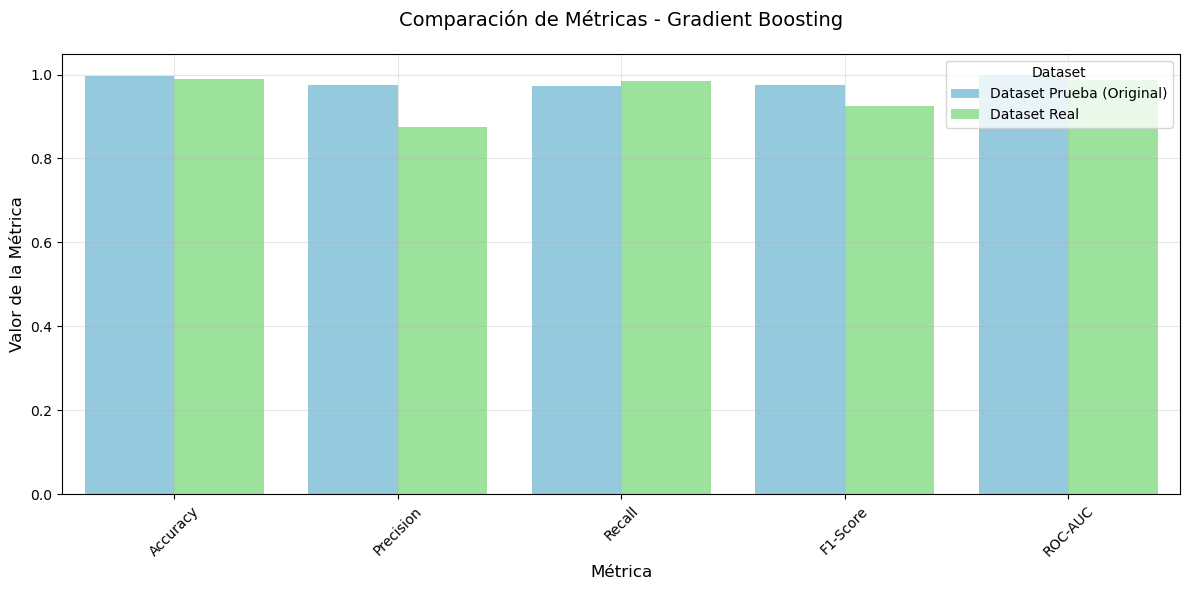

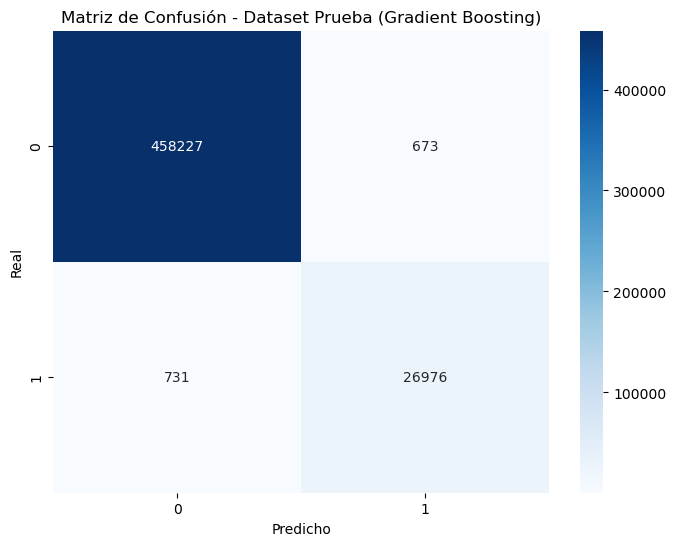

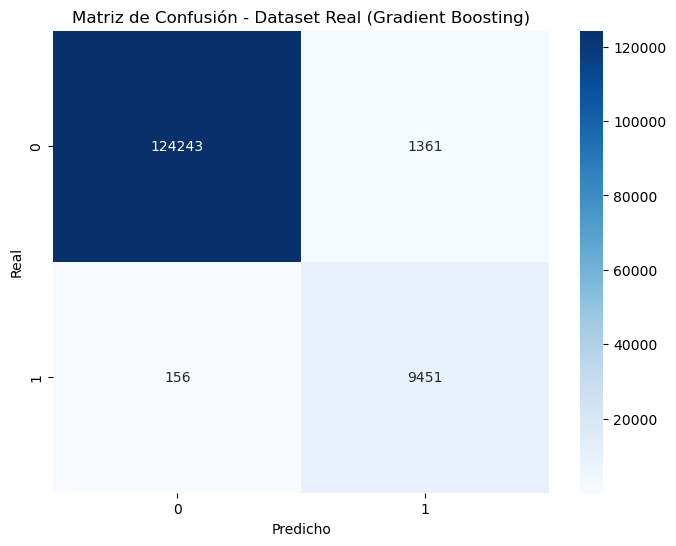

In [29]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Función para calcular métricas
def calcular_metricas(modelo, X, y):
    y_pred = modelo.predict(X)
    y_pred_proba = modelo.predict_proba(X)[:, 1]
    
    roc_auc = roc_auc_score(y, y_pred_proba)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    
    return {
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4)
    }

# Cargar datasets
df_mora_prestamos_original = pd.read_csv('C:/Users/g97rojasmf/Documents/Tesis/df_mora_prestamos2.csv')
nuevo_dataset = pd.read_csv('C:/Users/g97rojasmf/Documents/Tesis/df_mora_prestamos_202401.csv')

# Separar características y variable objetivo
X_original = df_mora_prestamos_original.drop('Morosidad', axis=1)
y_original = df_mora_prestamos_original['Morosidad']
X_nuevo = nuevo_dataset.drop('Morosidad', axis=1)
y_nuevo = nuevo_dataset['Morosidad']

# Asegurar nombres consistentes
X_original.columns = X_original.columns.str.replace(' ', '_')
X_nuevo.columns = X_nuevo.columns.str.replace(' ', '_')

# Dividir datos del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_original, y_original, test_size=0.3, stratify=y_original, random_state=42
)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entrenar modelo con los mejores hiperparámetros de Gradient Boosting
modelo = GradientBoostingClassifier(
    subsample=0.9,
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=7,
    learning_rate=0.05,
    random_state=42
)

print("Entrenando Gradient Boosting con los mejores hiperparámetros...")
modelo.fit(X_train_smote, y_train_smote)

# Calcular métricas en conjunto de prueba original
metricas_test = calcular_metricas(modelo, X_test, y_test)

# Calcular métricas en nuevo dataset
metricas_nuevo = calcular_metricas(modelo, X_nuevo, y_nuevo)

# Comparar métricas
comparacion_metricas = pd.DataFrame({
    'Métrica': list(metricas_test.keys()),
    'Dataset Prueba (Original)': list(metricas_test.values()),
    'Dataset Real': list(metricas_nuevo.values()),
    'Desvío': [
        round(abs(metricas_test[m] - metricas_nuevo[m]), 4) for m in metricas_test
    ]
})

# Mostrar resultados
print("\nComparación de Métricas entre Dataset Prueba (Original) y Dataset Real:")
print(comparacion_metricas)

# Visualizar comparación
plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparacion_metricas.melt(id_vars='Métrica', 
                                  value_vars=['Dataset Prueba (Original)', 'Dataset Real']),
    x='Métrica', 
    y='value', 
    hue='variable',
    palette=['skyblue', 'lightgreen']
)

plt.title("Comparación de Métricas - Gradient Boosting", fontsize=14, pad=20)
plt.ylabel("Valor de la Métrica", fontsize=12)
plt.xlabel("Métrica", fontsize=12)
plt.legend(title="Dataset", title_fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Matriz de confusión para conjunto de prueba
cm_test = confusion_matrix(y_test, modelo.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Dataset Prueba (Gradient Boosting)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Matriz de confusión para nuevo dataset
cm_nuevo = confusion_matrix(y_nuevo, modelo.predict(X_nuevo))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nuevo, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Dataset Real (Gradient Boosting)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Guardar resultados
resultados = {
    'metricas_test': metricas_test,
    'metricas_nuevo': metricas_nuevo,
    'matriz_confusion_test': cm_test.tolist(),
    'matriz_confusion_nuevo': cm_nuevo.tolist()
}

# Guardar en CSV
comparacion_metricas.to_csv('resultados_gradient_boosting.csv', index=False)